<a href="https://colab.research.google.com/github/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMDetection Tutorial

Welcome to MMDetection! This is the official colab tutorial for using MMDetection. In this tutorial, you will learn
- Perform inference with a MMDet detector.
- Train a new detector with a new dataset.

Let's start!


In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

/home/frans/miniconda3/envs/openmmlab/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.12.1 False
2.25.1
not available
GCC 9.4


## Perform inference with a MMDet detector
MMDetection already provides high level APIs to do inference and training.

In [2]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = '../configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = './checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
# model = init_detector(config, checkpoint, device='cuda:0')
model = init_detector(config, checkpoint, device='cpu')

load checkpoint from local path: ./checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


AssertionError: Torch not compiled with CUDA enabled

In [5]:
# Use the detector to do inference
img = './demo.jpg'
result = inference_detector(model, img)

/home/frans/miniconda3/envs/torchvision/lib/python3.8/site-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


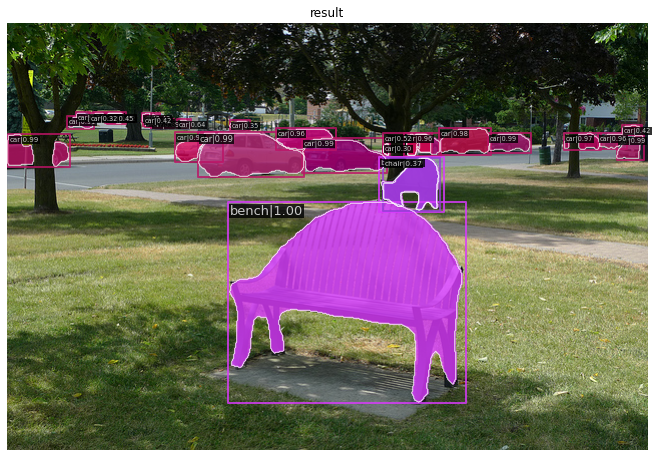

In [6]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3)

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



### Support a new dataset

There are three ways to support a new dataset in MMDetection: 
  1. reorganize the dataset into COCO format.
  2. reorganize the dataset into a middle format.
  3. implement a new dataset.

Usually we recommend to use the first two methods which are usually easier than the third.

In this tutorial, we gives an example that converting the data into the format of existing datasets like COCO, VOC, etc. Other methods and more advanced usages can be found in the [doc](https://mmdetection.readthedocs.io/en/latest/tutorials/new_dataset.html#).

Firstly, let's download a tiny dataset obtained from [KITTI](http://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d). We select the first 75 images and their annotations from the 3D object detection dataset (it is the same dataset as the 2D object detection dataset but has 3D annotations). We convert the original images from PNG to JPEG format with 80% quality to reduce the size of dataset.

In [7]:
# Check the directory structure of the tiny data
import os

list_train_images = os.listdir('./200224/training/images')
#list_train_images = ['./200224/training/images/{0}'.format(i) for i in list_train_images]
list_train_images

['200224_B2.tif',
 '200224_B3.tif',
 '200224_B4.tif',
 '200224_B5.tif',
 '200224_B6.tif',
 '200224_B7.tif',
 '200224_C3.tif',
 '200224_C4.tif',
 '200224_C5.tif',
 '200224_C6.tif']

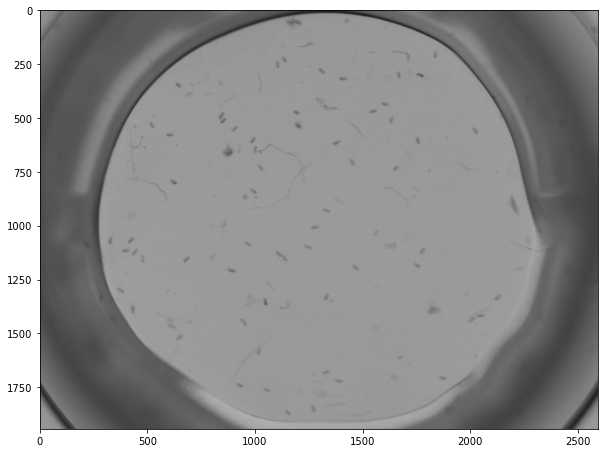

In [8]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('./200224/training/images/'+list_train_images[0])
plt.figure(figsize=(10, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

After downloading the data, we need to implement a function to convert the kitti annotation format into the middle format. In this tutorial we choose to convert them in **`load_annotations`** function in a newly implemented **`KittiTinyDataset`**.

Let's take a look at the annotation txt file.



In [9]:
import json 

with open('./200224/training/annotations/instances_default.json','r') as jsonfile:
    annot_data = json.load(jsonfile)

#print(annot_data)
#print(annot_data['images']) 
print(annot_data['annotations'][0])

#[l['id'] for l in annot_data['images']]

{'id': 1, 'image_id': 14, 'category_id': 3, 'segmentation': [], 'area': 19497.950899999974, 'bbox': [1649.8, 1650.21, 159.31, 122.39], 'iscrowd': 0, 'attributes': {'occluded': False}}


In [1]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

from mmdet.apis import inference_detector, init_detector, show_result_pyplot

# Choose to use a config and initialize the detector
config = '../configs/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco.py'
# Setup a checkpoint file to load
checkpoint = './checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')

import os

list_train_images = os.listdir('./200224/training/images')

import json 

with open('./200224/training/annotations/instances_default.json','r') as jsonfile:
    annot_data = json.load(jsonfile)

@DATASETS.register_module()
class HatchingDataset(CustomDataset):

    CLASSES = ('Juvenile',)

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
        # image_list = list_train_images        
        data_infos = []
        #print(list_train_images)
        # convert annotations to middle format
        for fname in image_list:
            bboxes = []
            bbox_names=[]
            filepath = './200224/training/images/{0}'.format(fname)
            print(filepath)
            image = mmcv.imread(filepath)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{fname}', width=width, height=height)
    
            # load annotations
             # load annotations
            image_id = [i['id'] for i in annot_data['images'] if i['file_name']==fname][0]
            bounding_boxes = [b['bbox'] for b in annot_data['annotations'] if b['image_id']==image_id]
            
            for bbox_coco in bounding_boxes:
                bbox_kitty = [bbox_coco[0], bbox_coco[1], bbox_coco[0]+bbox_coco[2], bbox_coco[1]+bbox_coco[3]]                                                      
                bboxes.append(bbox_kitty)            
                bbox_names.append('Juvenile')

            # label_prefix = self.img_prefix.replace('image_2', 'label_2')
            # lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            # content = [line.strip().split(' ') for line in lines]

            # bbox_names = [x[0] for x in content]
            # bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos




1.10.2 False
2.21.0
not available
GCC 7.3
load checkpoint from local path: ./checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [2]:
from mmcv import Config
cfg = Config.fromfile('../configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [3]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'HatchingDataset'
cfg.data_root = '200224/'

cfg.data.test.type = 'HatchingDataset'
cfg.data.test.data_root = '200224/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/images'

cfg.data.train.type = 'HatchingDataset'
cfg.data.train.data_root = '200224/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/images'

cfg.data.val.type = 'HatchingDataset'
cfg.data.val.data_root = '200224/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 1

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.runner.max_epochs = 4
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe',
        init_cfg=dict(
            type='Pretrained',
            checkpoint='open-mmlab://detectron2/resnet50_caffe')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='Cro

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [4]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

./200224/training/images/200224_B2.tif
./200224/training/images/200224_B3.tif
./200224/training/images/200224_B4.tif


/home/frans/miniconda3/envs/openmmlab/lib/python3.7/site-packages/ipykernel_launcher.py:98: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/frans/miniconda3/envs/openmmlab/lib/python3.7/site-packages/ipykernel_launcher.py:101: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not

./200224/training/images/200224_B5.tif
./200224/training/images/200224_B6.tif
./200224/training/images/200224_B7.tif
./200224/training/images/200224_C3.tif
./200224/training/images/200224_C4.tif
./200224/training/images/200224_C5.tif
./200224/training/images/200224_C6.tif


/home/frans/miniconda3/envs/openmmlab/lib/python3.7/site-packages/mmdet/datasets/custom.py:180: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')


./200224/training/images/200224_B2.tif
./200224/training/images/200224_B3.tif
./200224/training/images/200224_B4.tif
./200224/training/images/200224_B5.tif
./200224/training/images/200224_B6.tif
./200224/training/images/200224_B7.tif
./200224/training/images/200224_C3.tif
./200224/training/images/200224_C4.tif
./200224/training/images/200224_C5.tif


2022-02-25 15:32:36,617 - mmdet - INFO - load checkpoint from local path: checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth


./200224/training/images/200224_C6.tif


2022-02-25 15:32:37,001 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([4]).
unexpected key in source state_dict: roi_head.mask_head.convs.0.conv.weight, roi_head.mask_head.convs.0.conv.bias, roi_head.mask_head.convs.1.conv.weight, roi_head.mask_head.convs.1.conv.bias, roi_head.mask_head.convs.2.conv.weight, roi_hea

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 0.2 task/s, elapsed: 49s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-25 15:34:43,587 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| Juvenile | 103 | 1000 | 0.845  | 0.328 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.328 |
+----------+-----+------+--------+-------+
2022-02-25 15:34:43,592 - mmdet - INFO - Epoch(val) [1][10]	AP50: 0.3280, mAP: 0.3280
2022-02-25 15:35:07,941 - mmdet - INFO - Epoch [2][1/5]	lr: 2.500e-03, eta: 0:03:55, time: 24.327, data_time: 2.615, loss_rpn_cls: 0.1204, loss_rpn_bbox: 0.1119, loss_cls: 0.5151, acc: 78.9062, loss_bbox: 0.7127, loss: 1.4601
2022-02-25 15:35:27,680 - mmdet - INFO - Epoch [2][2/5]	lr: 2.500e-03, eta: 0:03:44, time: 19.739, data_time: 0.022, loss_rpn_cls: 0.0764, loss_rpn_bbox: 0.0928, loss_cls: 0.4421, acc: 79.7852, loss_bbox: 0.6877, loss: 1.2989
2022-02-25 15:35:43,103 - mmdet - INFO - Epoch [2][3/5]	lr: 2.500e-03, eta: 0:03:24, time: 15.423, data_time: 0.023, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 0.2 task/s, elapsed: 46s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-25 15:37:00,663 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| Juvenile | 103 | 1000 | 0.922  | 0.476 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.476 |
+----------+-----+------+--------+-------+
2022-02-25 15:37:00,666 - mmdet - INFO - Epoch(val) [2][10]	AP50: 0.4760, mAP: 0.4756
2022-02-25 15:37:20,407 - mmdet - INFO - Epoch [3][1/5]	lr: 2.500e-03, eta: 0:02:32, time: 19.728, data_time: 2.354, loss_rpn_cls: 0.0324, loss_rpn_bbox: 0.0438, loss_cls: 0.2617, acc: 90.1367, loss_bbox: 0.4475, loss: 0.7854
2022-02-25 15:37:37,407 - mmdet - INFO - Epoch [3][2/5]	lr: 2.500e-03, eta: 0:02:15, time: 17.000, data_time: 0.016, loss_rpn_cls: 0.0335, loss_rpn_bbox: 0.0870, loss_cls: 0.3046, acc: 88.2812, loss_bbox: 0.5144, loss: 0.9394
2022-02-25 15:37:54,891 - mmdet - INFO - Epoch [3][3/5]	lr: 2.500e-03, eta: 0:01:58, time: 17.485, data_time: 0.020, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 0.2 task/s, elapsed: 41s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-25 15:39:11,903 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| Juvenile | 103 | 903  | 0.961  | 0.564 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.564 |
+----------+-----+------+--------+-------+
2022-02-25 15:39:11,907 - mmdet - INFO - Epoch(val) [3][10]	AP50: 0.5640, mAP: 0.5644
2022-02-25 15:39:34,875 - mmdet - INFO - Epoch [4][1/5]	lr: 2.500e-03, eta: 0:01:09, time: 22.949, data_time: 2.463, loss_rpn_cls: 0.0474, loss_rpn_bbox: 0.0470, loss_cls: 0.3048, acc: 84.4727, loss_bbox: 0.6602, loss: 1.0594
2022-02-25 15:39:53,376 - mmdet - INFO - Epoch [4][2/5]	lr: 2.500e-03, eta: 0:00:52, time: 18.501, data_time: 0.019, loss_rpn_cls: 0.0305, loss_rpn_bbox: 0.0332, loss_cls: 0.2401, acc: 89.8438, loss_bbox: 0.5200, loss: 0.8239
2022-02-25 15:40:07,914 - mmdet - INFO - Epoch [4][3/5]	lr: 2.500e-03, eta: 0:00:34, time: 14.537, data_time: 0.019, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 10/10, 0.2 task/s, elapsed: 44s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-02-25 15:41:25,666 - mmdet - INFO - 
+----------+-----+------+--------+-------+
| class    | gts | dets | recall | ap    |
+----------+-----+------+--------+-------+
| Juvenile | 103 | 698  | 0.981  | 0.663 |
+----------+-----+------+--------+-------+
| mAP      |     |      |        | 0.663 |
+----------+-----+------+--------+-------+
2022-02-25 15:41:25,669 - mmdet - INFO - Epoch(val) [4][10]	AP50: 0.6630, mAP: 0.6629


### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

/home/frans/miniconda3/envs/openmmlab/lib/python3.7/site-packages/mmdet/datasets/utils.py:69: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


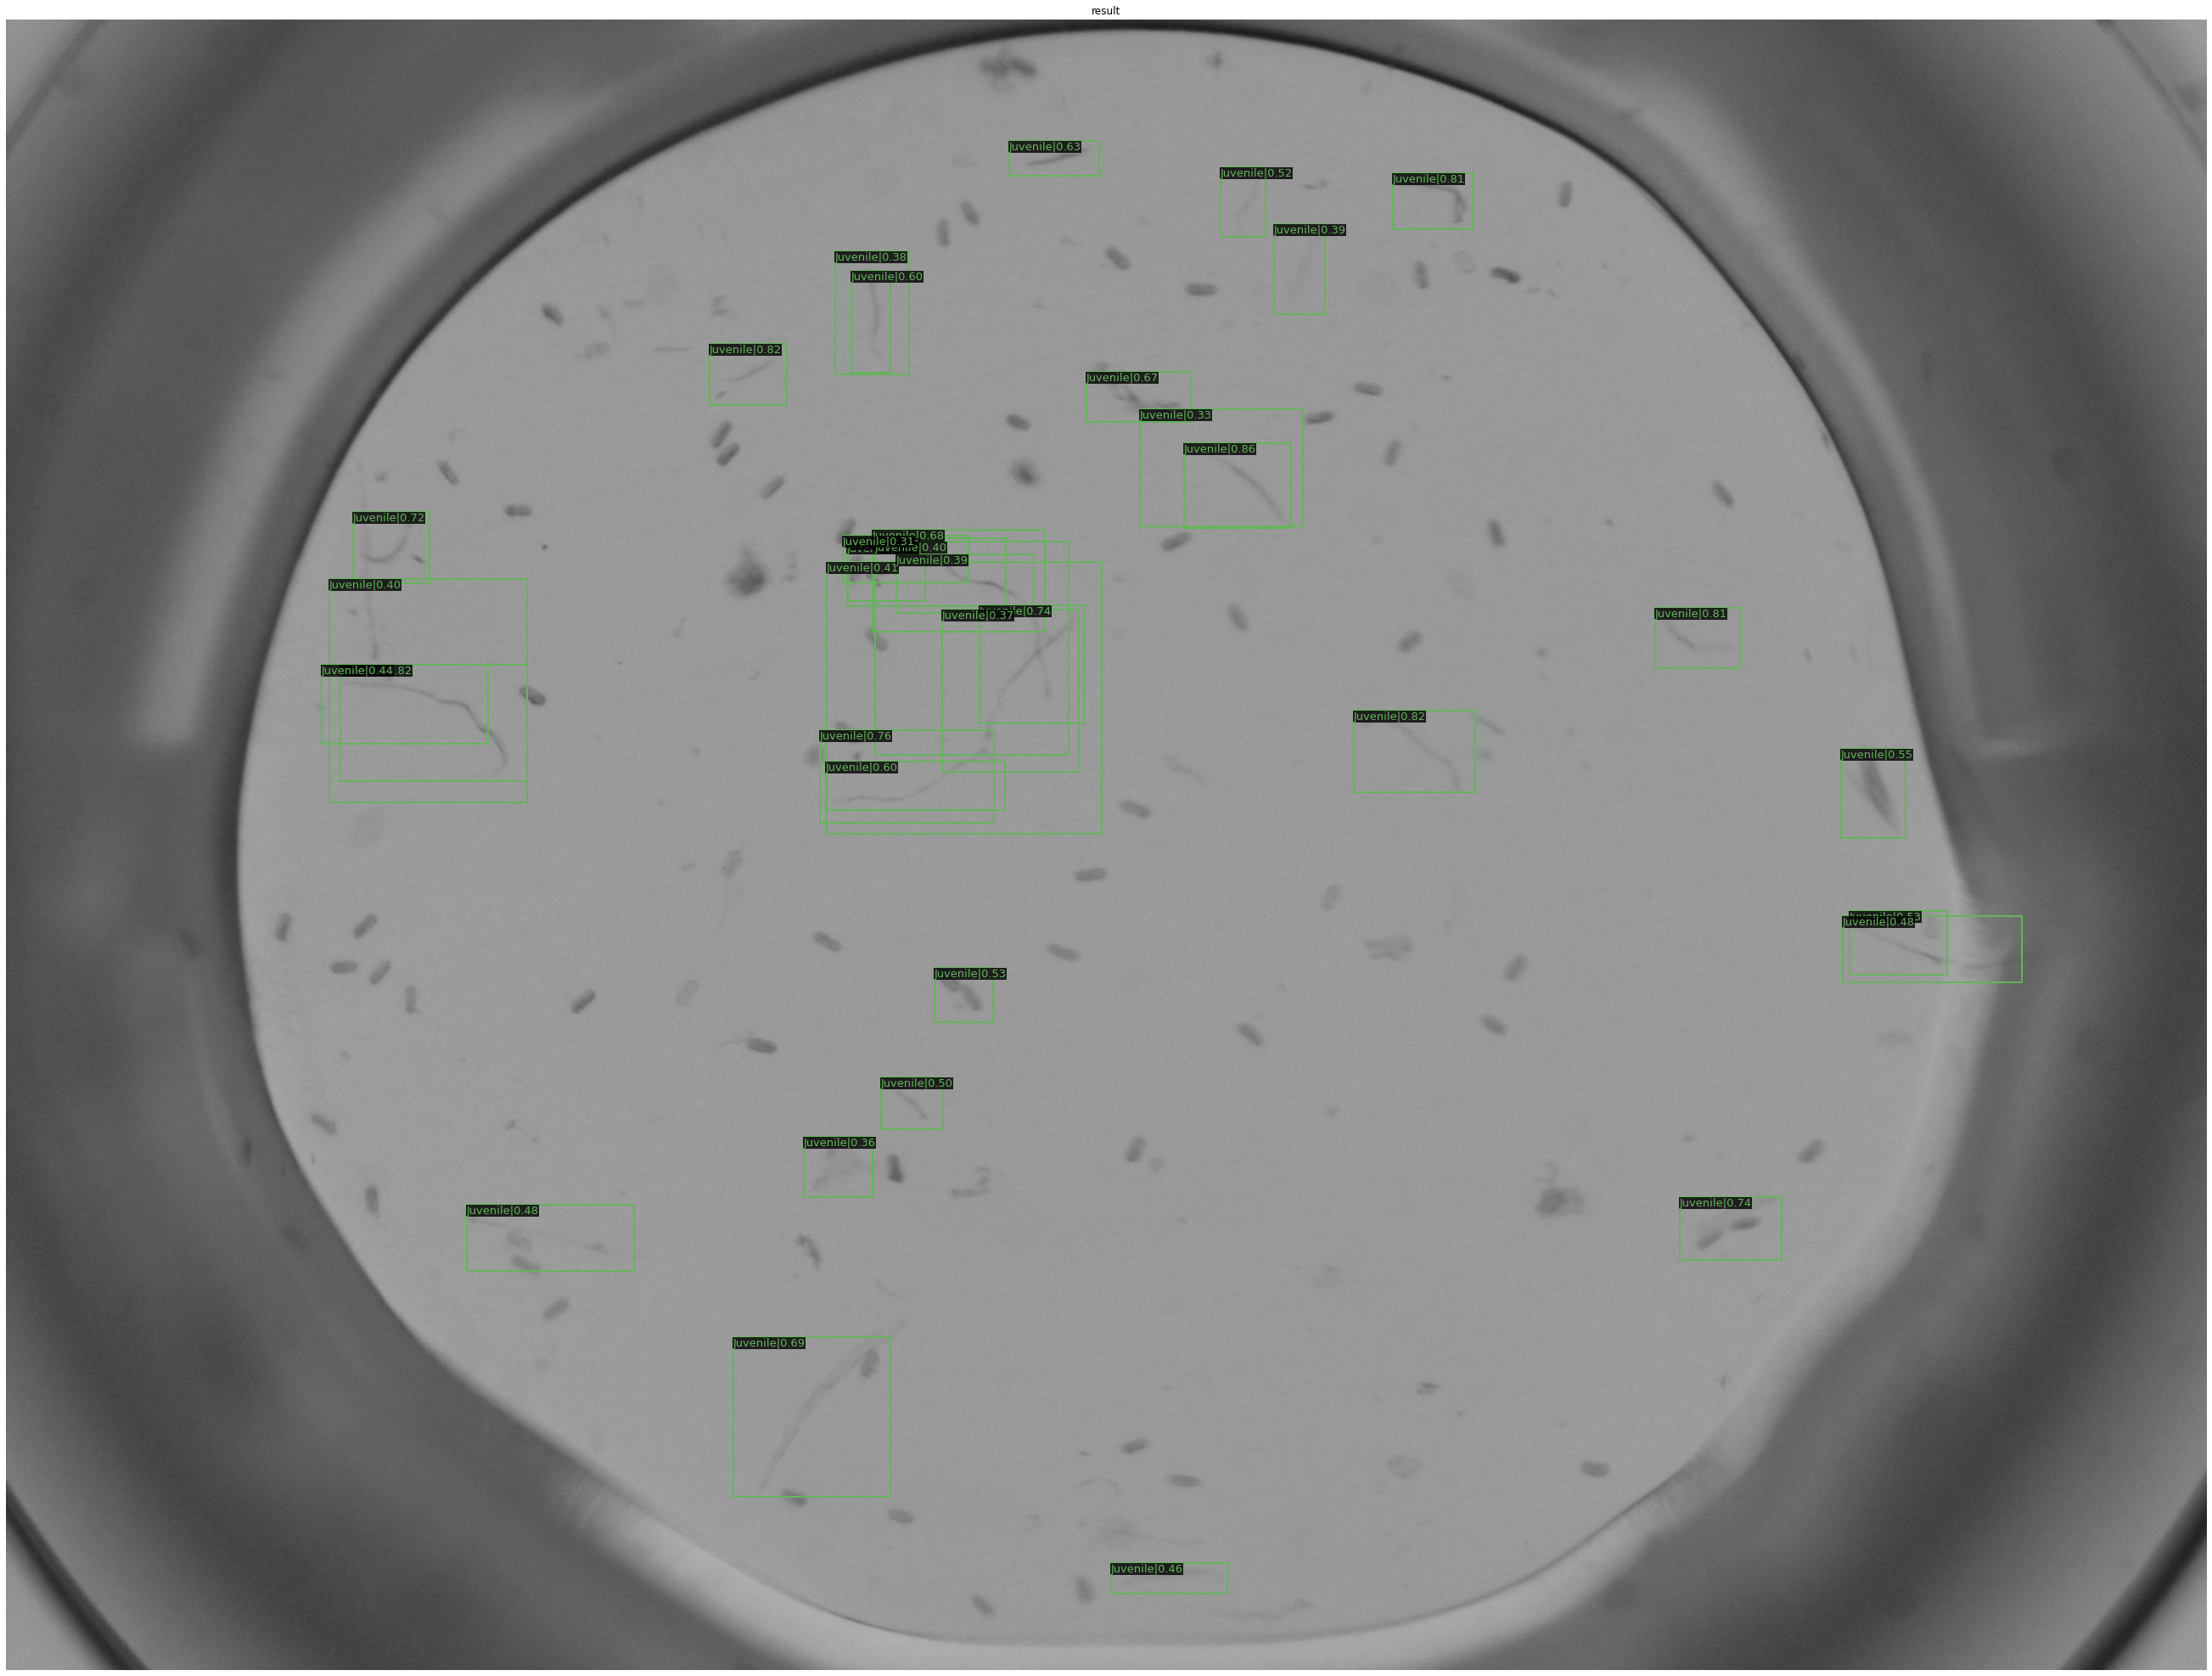

In [5]:
img = mmcv.imread('200224/training/images/200224_B2.tif')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


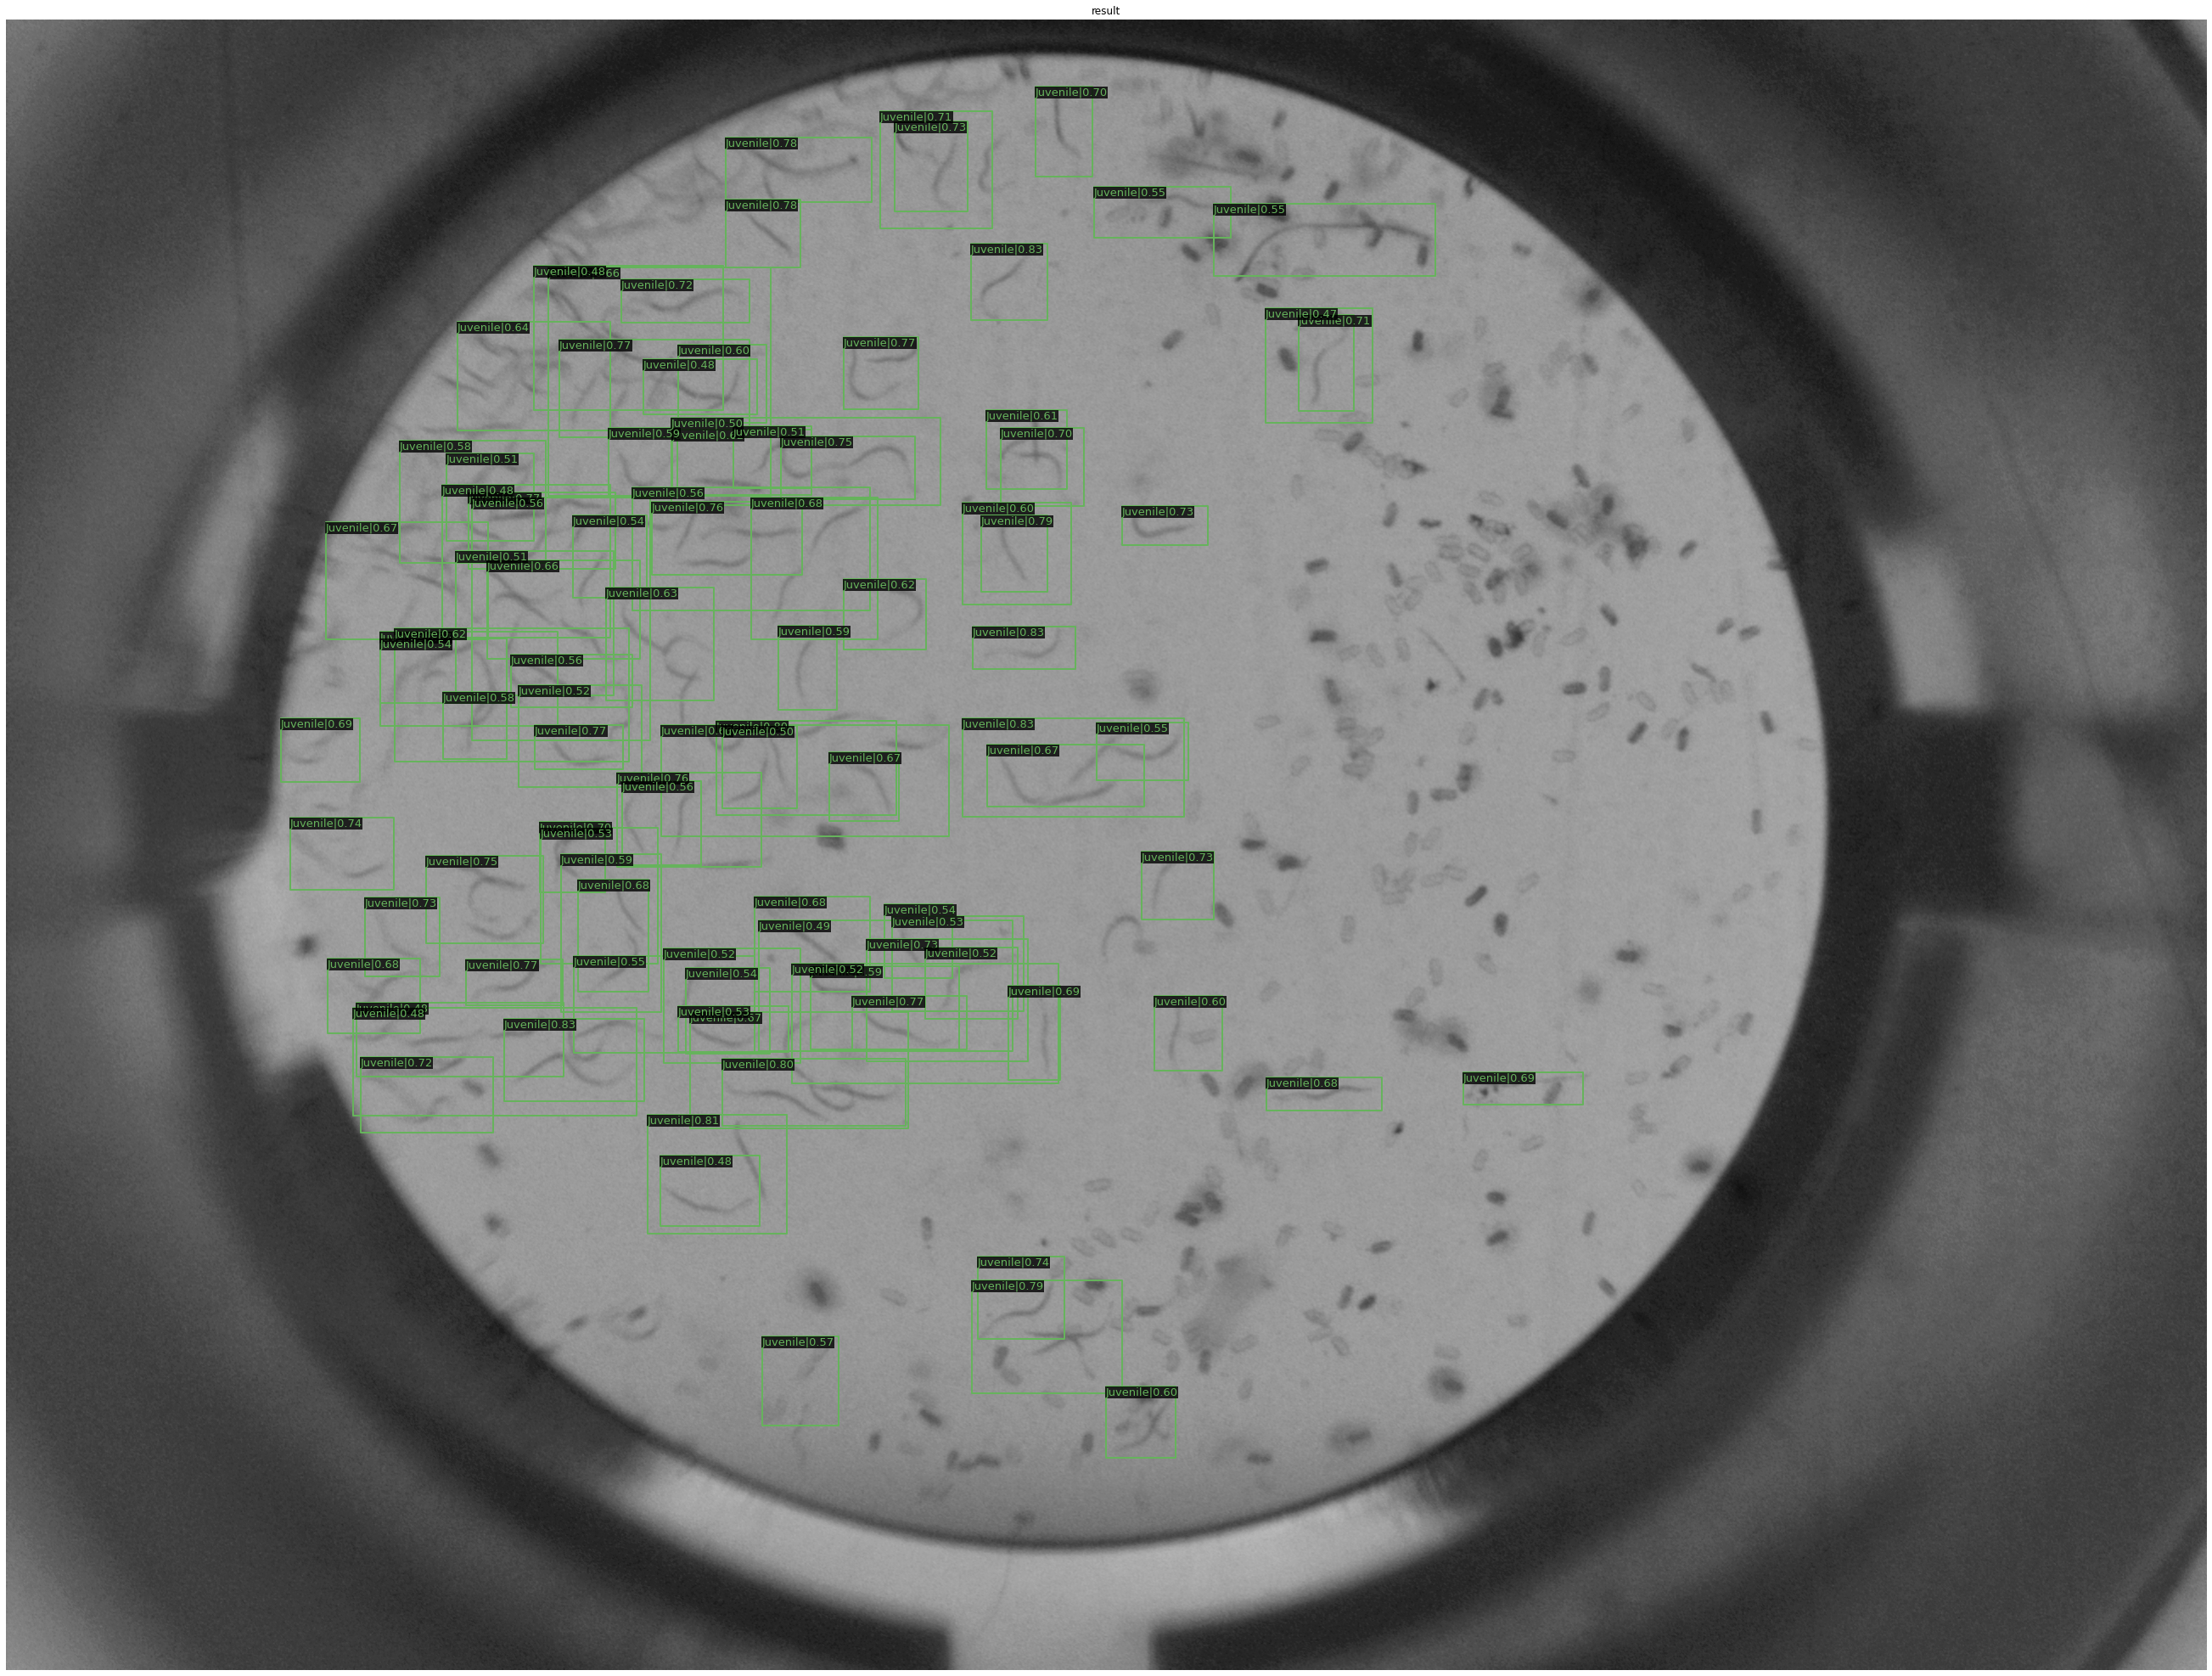

In [8]:
img = mmcv.imread('200224/val/images/180704_Gros_F4.tiff')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)